<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/master/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

In [89]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

In [90]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [91]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

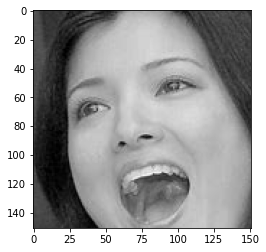

In [92]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [93]:
detect(face_cascade, './data/mask/1.jpg')

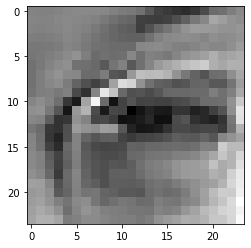

In [94]:
detect(eye_cascade, './data/mask/1.jpg')

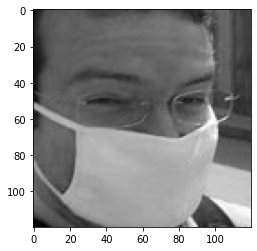

In [95]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

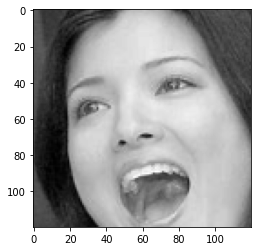

In [96]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

1.jpg


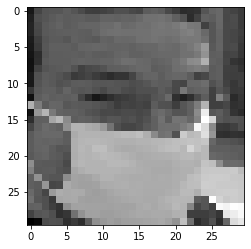

9.jpg


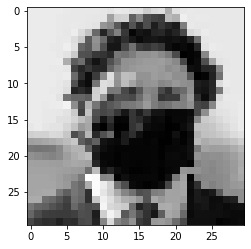

8.jpg


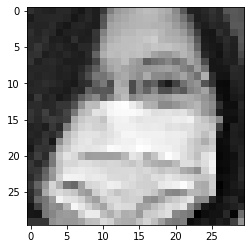

5.jpg


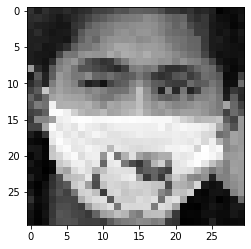

6.jpg


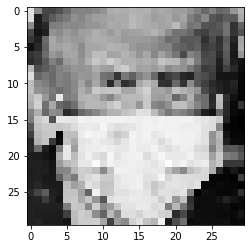

10.jpg


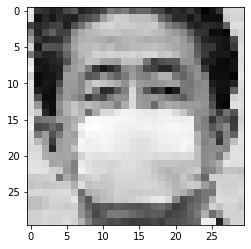

7.jpg


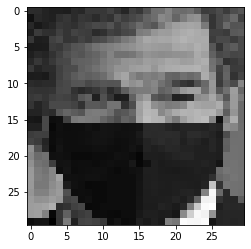

3.jpg


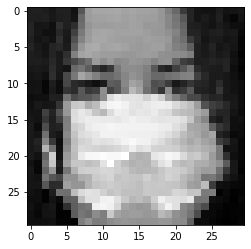

4.jpg


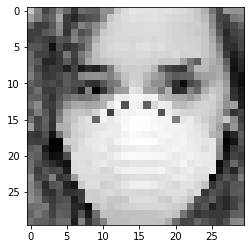

2.jpg


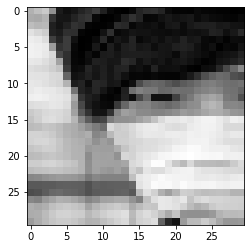

(10, 30, 30)

In [97]:
def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=(30, 30))))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

1.jpg


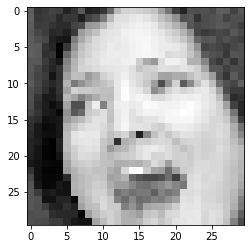

9.jpg


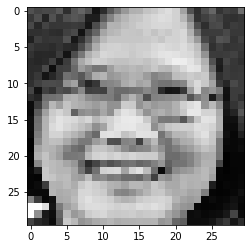

8.jpg


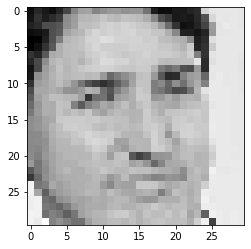

5.jpg


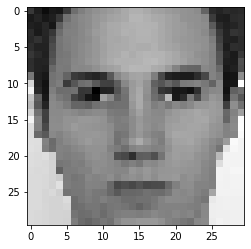

6.jpg


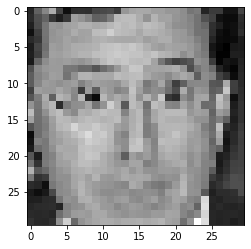

10.jpg


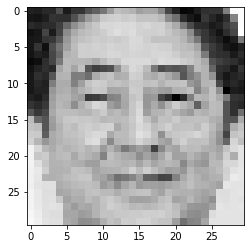

7.jpg


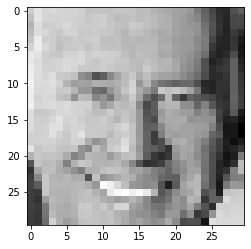

3.jpg


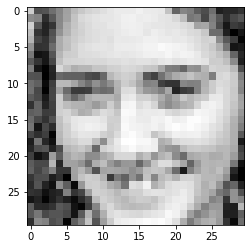

4.jpg


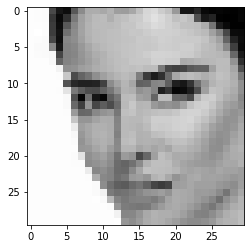

2.jpg


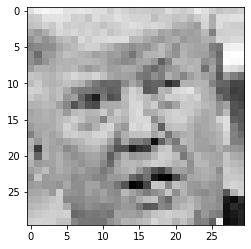

(10, 30, 30)

In [98]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [99]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [100]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 30, 30)

In [101]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 900)

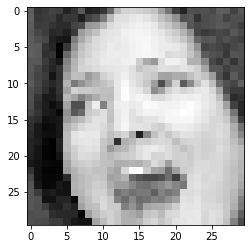

In [102]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [103]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.23543153, 0.16206838, 0.1463292 , 0.09482794, 0.05546507,
       0.05486189, 0.03294928, 0.03108006, 0.0299053 , 0.02449923,
       0.02268278, 0.01927455, 0.01768584, 0.01676508, 0.01360406])

In [104]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

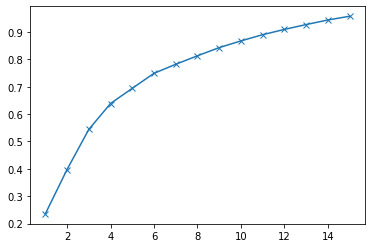

In [105]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [106]:
# choose 5 features, since we only have 20 rows
pca = PCA(n_components=5)
Z = pca.fit_transform(X_scaled)

In [107]:
# let's do a pairplot
df = pd.DataFrame(Z)
df['label'] = labels
df.head()

,0,1,2,3,4,label
0,-7.336894,5.665424,-11.854936,-5.680977,-2.363866,nomask
1,-9.331147,3.346021,-8.435490,5.028124,-10.531480,nomask
2,0.557318,-14.090079,-2.176725,-6.649780,1.789471,nomask
3,7.620483,-3.527558,-2.674122,-12.171269,1.703065,nomask
4,8.233754,13.798595,-2.214137,2.371012,1.846945,nomask


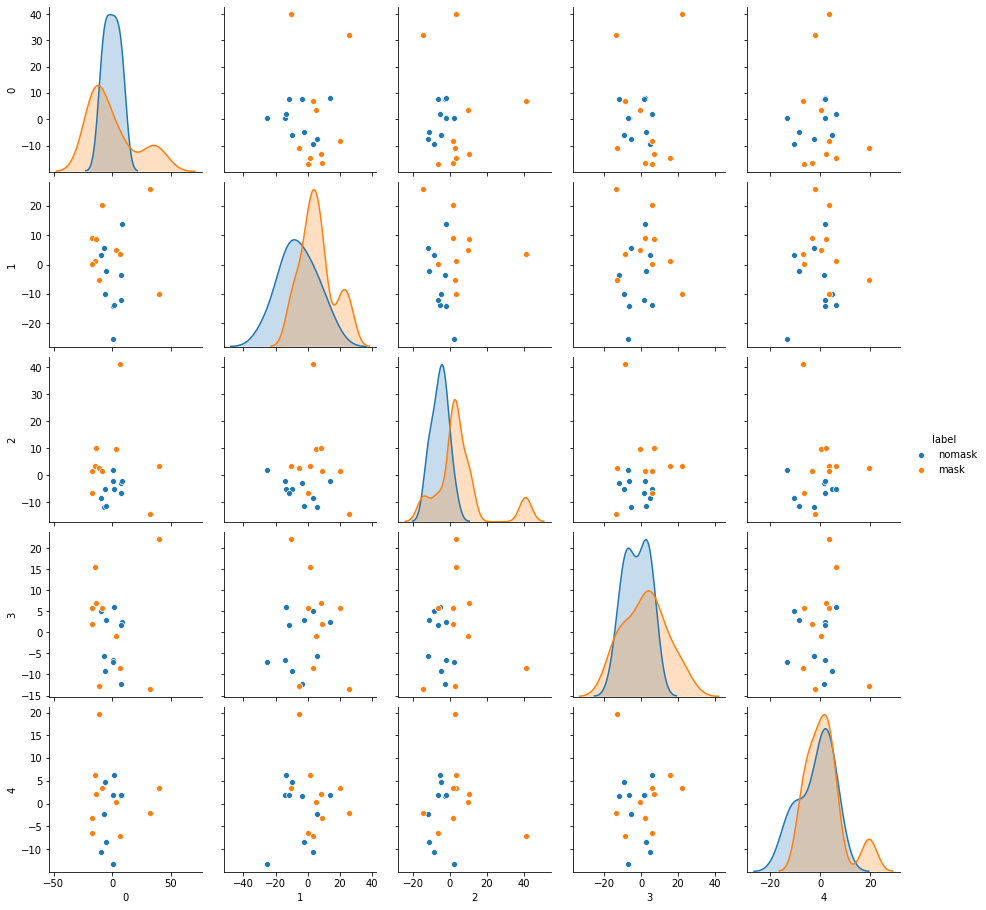

In [108]:
sns.pairplot(df, hue='label')

In [109]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [111]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [112]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



## Neural Networks

In [113]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [114]:
mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=100,
                  validation_data=(X_test, y_test))

Epoch 1/100
3/3 [==============================] - 0s 48ms/step - loss: 4.7757 - accuracy: 0.2667 - val_loss: 1.3242 - val_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 4.7091 - accuracy: 0.2667 - val_loss: 1.3053 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 4.6376 - accuracy: 0.2667 - val_loss: 1.2859 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 4.5781 - accuracy: 0.2667 - val_loss: 1.2663 - val_accuracy: 0.4000
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 4.5327 - accuracy: 0.2667 - val_loss: 1.2470 - val_accuracy: 0.4000
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 4.4607 - accuracy: 0.2667 - val_loss: 1.2294 - val_accuracy: 0.4000
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 4.4052 - accuracy: 0.2667 - val_loss: 1.2117 - val_accuracy: 0.4000
Epoch 8/100
3/3 [===

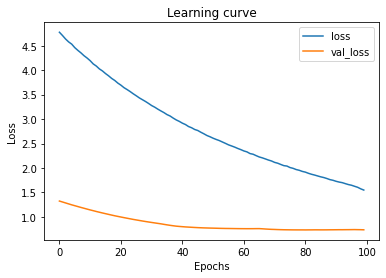

In [115]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [116]:
mlp.save('mlp.h5')

In [117]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [118]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5



In [119]:
# try without PCA, because NN can do dimensionality reduction automatically
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

mlp_full = tf.keras.Sequential()
mlp_full.add(layers.Dense(5, input_shape=(X_train.shape[1],), activation='relu'))
mlp_full.add(layers.Dense(1, activation='sigmoid'))
mlp_full.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 5)                 4505      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 6         
Total params: 4,511
Trainable params: 4,511
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
3/3 [==============================] - 0s 43ms/step - loss: 1.1578 - accuracy: 0.2000 - val_loss: 0.8384 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 0.6112 - accuracy: 0.6667 - val_loss: 0.8622 - val_accuracy: 0.4000
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.4068 - accuracy: 0.8667 - val_loss: 0.8883 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3257 - accuracy: 0.8667 - val_loss: 0.9263 - val_accuracy: 0.8000
Epoch 5/50
3/3 [==============================] - 0s 14ms/step - loss: 0.2825 - accuracy: 0.8667 - val_loss: 0.9313 - val_accuracy: 0.8000
Epoch 6/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2297 - accuracy: 0.9333 - val_loss: 0.9311 - val_accuracy: 0.8000
Epoch 7/50
3/3 [==============================] - 0s 19ms/step - loss: 0.2053 - accuracy: 0.9333 - val_loss: 0.9276 - val_accuracy: 0.8000
Epoch 8/50
3/3 [===========

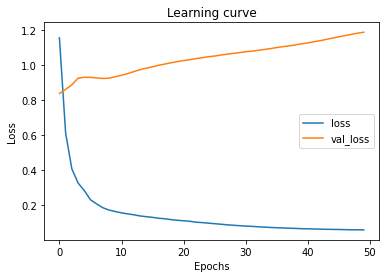

In [120]:
mlp_full.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp_full.fit(X_train, y_train, batch_size=5, epochs=50,
                      validation_data=(X_test, y_test))
mlp_full.save('mlp_full.h5')

# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [121]:
y_pred_mlp = mlp_full.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



## Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [122]:
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_full)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('mlp_full.tflite', 'wb').write(tflite_model)

5720

In [123]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='mlp_full.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [124]:
!pip install tinymlgen

In [125]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(mlp_full)
with open('mlp_full.h', 'w') as f:
  f.write(c_code)

print(c_code)


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x0c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00, 0x96, 0xed, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x14, 0x16, 0x00, 0x00, 0x54, 0x12, 0x00, 0x00, 0x3c, 0x12, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 0x2c, 0x12, 0x00, 0x00, 0x24, 0x12, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0xe4, 0x11, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x4c, 0xea, 0xff, 0xff, 0x50, 0xea, 0xff, 0xff, 0x54, 0xea, 0xff, 0xff, 0x2e, 0xee, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x85, 0x7e, 0x0a, 0x3e, 0x9f, 0x5c, 0x0a, 0xbf, 0x9f, 0xde,

In [126]:
with open('mlp_full.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x0c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00, 0x96, 0xed, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x14, 0x16, 0x00, 0x00, 0x54, 0x12, 0x00, 0x00, 0x3c, 0x12, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 0x2c, 0x12, 0x00, 0x00, 0x24, 0x12, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0xe4, 0x11, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x4c, 0xea, 0xff, 0xff, 0x50, 0xea, 0xff, 0xff, 0x54, 0xea, 0xff, 0xff, 0x2e, 0xee, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x85, 0x7e, 0x0a, 0x3e, 0x9f, 0x5c, 0x0a, 0xbf, 0x9f, 0xde,

In [127]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'X' : X,
    'y' : y,
    'X_scaler' : scaler,
    'X_pca' : pca,
    'y_encoder' : le,
    'lr' : lr,
    'mlp_filename' : 'mlp_full.h5', 
    'tflite_filename': 'mlp_full.tflite',
    'h_filename' : 'mlp_full.h'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))